In [1]:
import os
import shutil
import pandas as pd

In [2]:
skin_cancer = 'dataset/Skin_Cancer_Dataset'
normal_skin = 'dataset/normal'
results = 'dataset/result'

os.makedirs(results, exist_ok=True)

labels = ['Basal Cell Carcinoma','Melanoma', 'Squamous Cell Carcinoma', 'Normal']
for label in labels:
  os.makedirs(os.path.join(results, label), exist_ok=True)

for label in labels[:-1]:
  label_path = os.path.join(skin_cancer, label)
  if os.path.exists(label_path):
    for file in os.listdir(label_path):
      shutil.copy(os.path.join(label_path, file), os.path.join(results, label))

for file in os.listdir(normal_skin):
  shutil.copy(os.path.join(normal_skin, file), os.path.join(results, 'Normal'))

In [3]:
from PIL import Image

def clean_data(directory):
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    if file in os.listdir(label_path):
      file_path = os.path.join(label_path, file)
      try:
        img = Image.open(file_path)
        img.verify()
        img = Image.open(file_path)
        img.load()
      except Exception as e:
        print(f"Delete: {file_path}, Error: {e}")
        os.remove(file_path)

clean_data(results)

                     class  count
0     Basal Cell Carcinoma    500
1                 Melanoma    505
2                   Normal    424
3  Squamous Cell Carcinoma    414


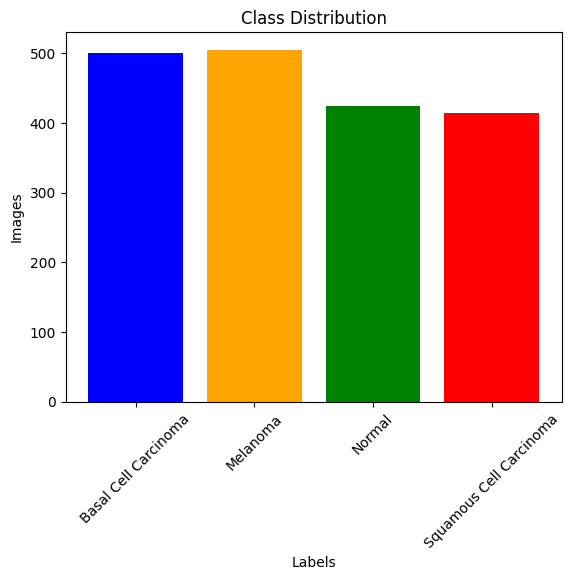

In [4]:
import matplotlib.pyplot as plt

def distribution_data(directory):
  count = {}
  for label in os.listdir(directory):
    label_path = os.path.join(directory, label)
    count[label] = len(os.listdir(label_path))
  return count

class_distribution = distribution_data(results)

# DataFrame distributions
df = pd.DataFrame(list(class_distribution.items()), columns=['class', 'count'])
print(df)

plt.bar(class_distribution.keys(), class_distribution.values(),
        color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Labels')
plt.ylabel('Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

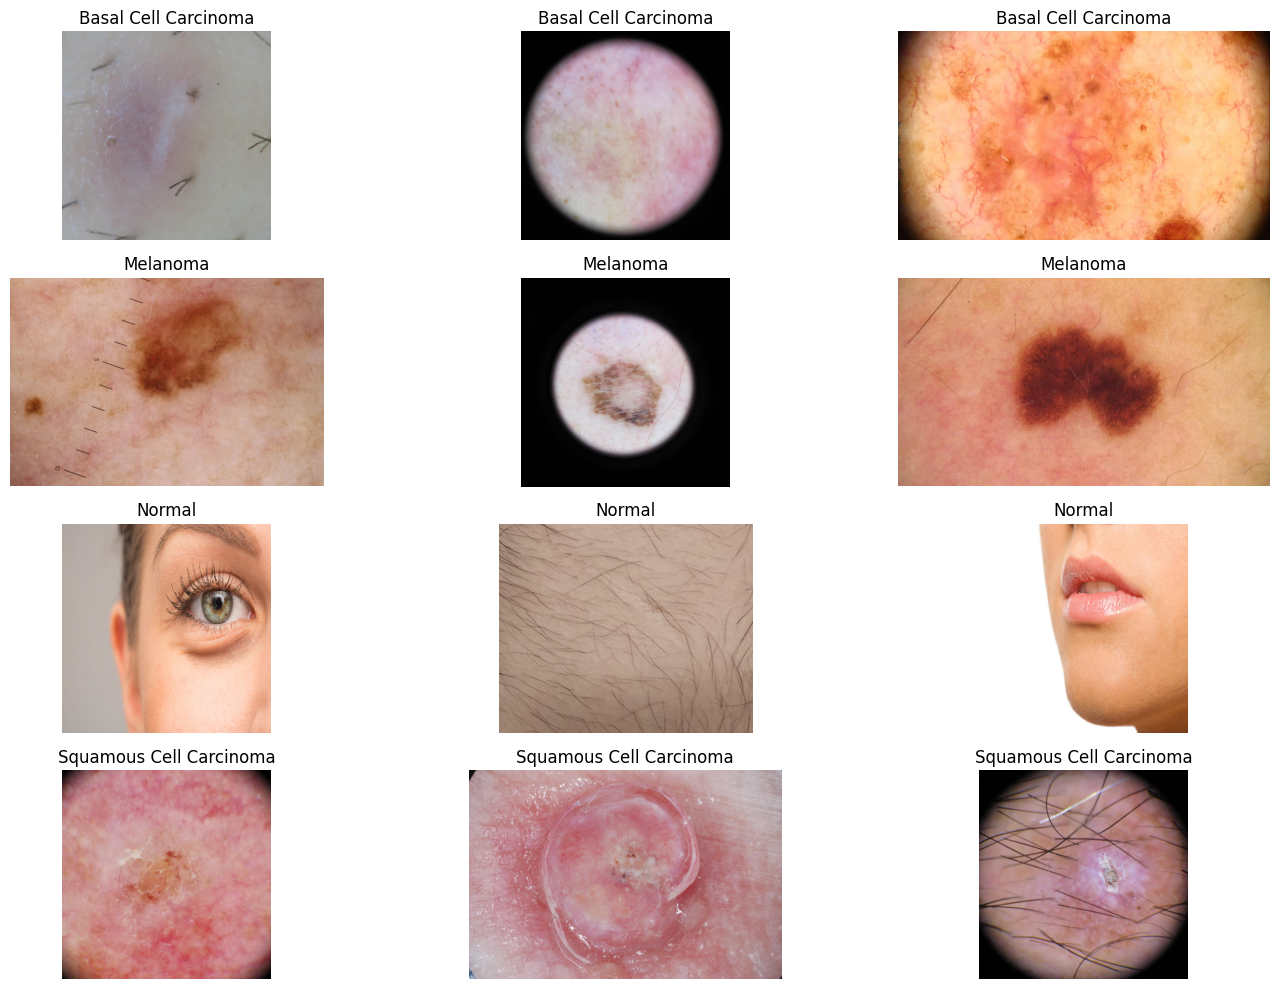

In [13]:
import random

# Visualisasi sampel gambar
def plot_sample_images(directory, classes, num_samples=3):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 10))
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        samples = random.sample(os.listdir(cls_path), num_samples)
        for j, sample in enumerate(samples):
            img_path = os.path.join(cls_path, sample)
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()


plot_sample_images(results, list(class_distribution.keys()))

In [6]:
# import numpy as np

# # Preprocess gambar
# def preprocess_images(directory, target_size=(224, 224)):
#     processed_data = []
#     labels = []
#     class_mapping = {cls: i for i, cls in enumerate(os.listdir(directory))}

#     for cls in os.listdir(directory):
#         cls_path = os.path.join(directory, cls)
#         for file in os.listdir(cls_path):
#             file_path = os.path.join(cls_path, file)
#             try:
#                 img = Image.open(file_path).resize(target_size)
#                 img_array = np.array(img) / 255.0  # Normalisasi
#                 processed_data.append(img_array)
#                 labels.append(class_mapping[cls])
#             except Exception as e:
#                 print(f"Error processing {file_path}: {e}")
#     return np.array(processed_data), np.array(labels)


# # Preprocess dataset
# X, y = preprocess_images(results)
# print(f"Processed data shape: {X.shape}, Labels shape: {y.shape}")

In [7]:
from sklearn.model_selection import train_test_split


def split_data(source, destination, split_ratio, labels):
  train = os.path.join(destination, 'train')
  val = os.path.join(destination, 'val')
  test =  os.path.join(destination, 'test')

  os.makedirs(train, exist_ok=True)
  os.makedirs(val, exist_ok=True)
  os.makedirs(test, exist_ok=True)

  for label in labels:
    label_path = os.path.join(source, label)
    files = os.listdir(label_path)

    # splitt 
    train_files, temp_files = train_test_split(files, test_size=(1 - split_ratios[0]), random_state=42)
    val_files, test_files = train_test_split(temp_files, test_size=(split_ratios[2] / sum(split_ratios[1:])), random_state=42)

    # Pindahkan file ke folder baru
    for phase, phase_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
        phase_dir = os.path.join(destination, phase, label)
        os.makedirs(phase_dir, exist_ok=True)
        for file in phase_files:
            shutil.copy(os.path.join(label_path, file), os.path.join(phase_dir, file))

# Path split data
split_ratios = [0.7, 0.2, 0.1]  # Train, Validation, Test
split_data(results, './dataset/split', split_ratios, labels)

## Aug

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Augmentasi data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Data generator
train_gen = train_datagen.flow_from_directory(
    './dataset/split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = val_test_datagen.flow_from_directory(
    './dataset/split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = val_test_datagen.flow_from_directory(
    './dataset/split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 1287 images belonging to 4 classes.
Found 369 images belonging to 4 classes.
Found 187 images belonging to 4 classes.


In [21]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Model dengan input shape yang sesuai
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                           input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=tf.keras.regularizers.L2(0.0001)),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 kelas output
])

optimizer_adam = Adam(learning_rate=1e-4)

d:\# Stupen\Hactiv8\capstone\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,124,740 (30.99 MB)

 Trainable params: 8,124,740 (30.99 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [24]:
model.compile(
    optimizer=optimizer_adam,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

eary_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1
)

In [25]:
history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // train_gen.batch_size,
    epochs=40,
    validation_data=val_gen,
    validation_steps=val_gen.samples // val_gen.batch_size,
    verbose=2,
    callbacks=[eary_stop, reduce_lr]
)

d:\# Stupen\Hactiv8\capstone\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/40
40/40 - 109s - 3s/step - accuracy: 0.2932 - loss: 1.4742 - val_accuracy: 0.4688 - val_loss: 1.4251 - learning_rate: 1.0000e-04
Epoch 2/40


d:\# Stupen\Hactiv8\capstone\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


40/40 - 13s - 333ms/step - accuracy: 0.4375 - loss: 1.4242 - val_accuracy: 0.4716 - val_loss: 1.4223 - learning_rate: 1.0000e-04
Epoch 3/40
40/40 - 83s - 2s/step - accuracy: 0.3865 - loss: 1.3998 - val_accuracy: 0.4716 - val_loss: 1.3037 - learning_rate: 1.0000e-04
Epoch 4/40
40/40 - 9s - 223ms/step - accuracy: 0.3750 - loss: 1.3750 - val_accuracy: 0.4886 - val_loss: 1.2953 - learning_rate: 1.0000e-04
Epoch 5/40
40/40 - 63s - 2s/step - accuracy: 0.4558 - loss: 1.2486 - val_accuracy: 0.5170 - val_loss: 1.1192 - learning_rate: 1.0000e-04
Epoch 6/40
40/40 - 9s - 229ms/step - accuracy: 0.4375 - loss: 1.0002 - val_accuracy: 0.5682 - val_loss: 1.1084 - learning_rate: 1.0000e-04
Epoch 7/40
40/40 - 63s - 2s/step - accuracy: 0.4733 - loss: 1.1937 - val_accuracy: 0.5966 - val_loss: 1.0720 - learning_rate: 1.0000e-04
Epoch 8/40
40/40 - 9s - 231ms/step - accuracy: 0.6250 - loss: 1.0616 - val_accuracy: 0.5909 - val_loss: 1.0592 - learning_rate: 1.0000e-04
Epoch 9/40
40/40 - 62s - 2s/step - accuracy

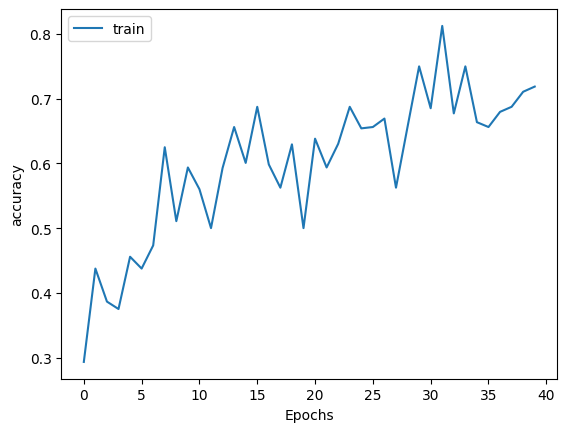

In [26]:
def PlotHistModel(hist, typePlt):
    plt.plot(hist.history[typePlt])
    plt.ylabel(typePlt)
    plt.xlabel('Epochs')
    plt.legend(['train'], loc='upper left')
    plt.show()


PlotHistModel(history, 'accuracy')

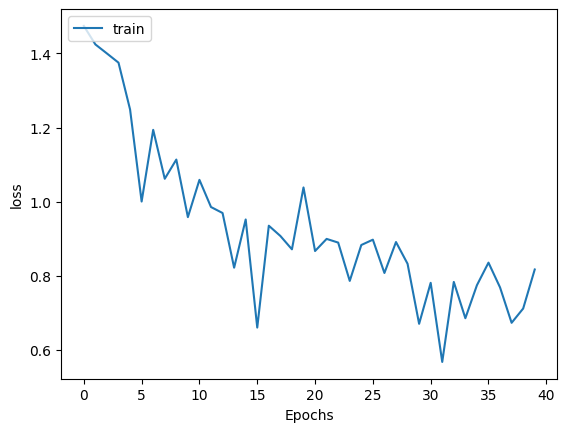

In [27]:
PlotHistModel(history, 'loss')

In [28]:
test_loss, test_acc = model.evaluate(val_gen)
print(f"Validation Loss: {test_loss}, Validation Accuracy: {test_acc}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 462ms/step - accuracy: 0.7583 - loss: 0.6927
Validation Loss: 0.6754153966903687, Validation Accuracy: 0.7615176439285278


In [29]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Mendapatkan prediksi
Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_gen.classes

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Mendapatkan label kelas
class_labels = list(val_gen.class_indices.keys())

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 514ms/step


In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_metrics_per_class(cm, class_idx):
    TP = cm[class_idx, class_idx]
    FP = np.sum(cm[:, class_idx]) - TP
    FN = np.sum(cm[class_idx, :]) - TP
    TN = np.sum(cm) - (TP + FP + FN)

    # Menghitung metrik
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision +
                                           recall) if (precision + recall) != 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1_score,
        'TP': TP,
        'FP': FP,
        'FN': FN,
        'TN': TN
    }


# Menghitung metrik untuk setiap kelas dan menyimpan dalam DataFrame
metrics_list = []
for idx, class_name in enumerate(class_labels):
    metrics = calculate_metrics_per_class(cm, idx)
    metrics['Class'] = class_name  # Menambahkan nama kelas
    metrics_list.append(metrics)

# Membuat DataFrame dari list metrik
df_metrics = pd.DataFrame(metrics_list)
df_metrics

,Accuracy,Precision,Recall,F1-Score,TP,FP,FN,TN,Class
0,0.563686,0.214953,0.230000,0.222222,23,84,77,185,Basal Cell Carcinoma
1,0.566396,0.252101,0.297030,0.272727,30,89,71,179,Melanoma
2,0.617886,0.174419,0.176471,0.175439,15,71,70,213,Normal
3,0.691057,0.228070,0.156627,0.185714,13,44,70,242,Squamous Cell Carcinoma


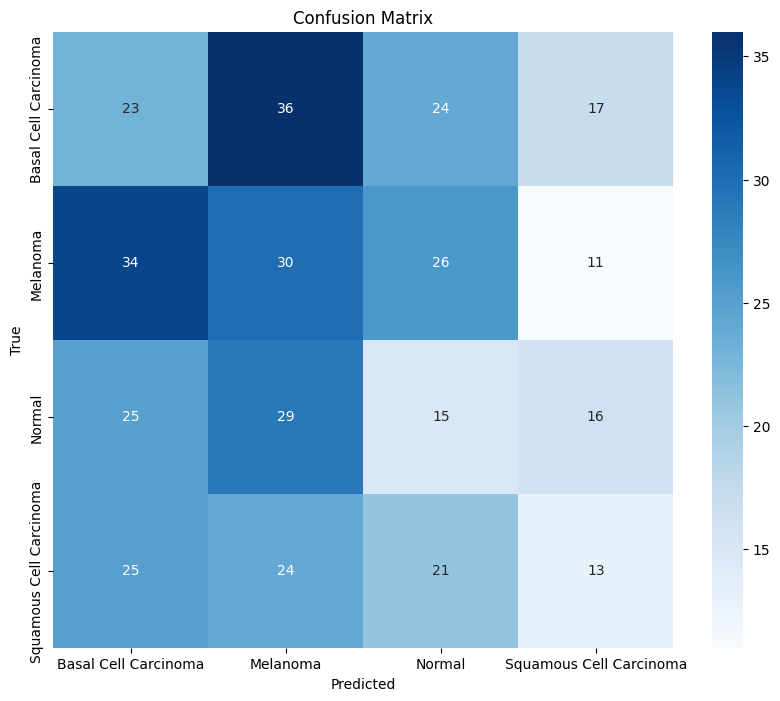

In [36]:

# Visualisasi confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [35]:
# def calculate_metrics_per_class(cm, class_idx):
#     TP = cm[class_idx, class_idx]
#     FP = np.sum(cm[:, class_idx]) - TP
#     FN = np.sum(cm[class_idx, :]) - TP
#     TN = np.sum(cm) - (TP + FP + FN)

#     # Menghitung metrik
#     accuracy = (TP + TN) / (TP + TN + FP + FN)
#     precision = TP / (TP + FP) if (TP + FP) != 0 else 0
#     recall = TP / (TP + FN) if (TP + FN) != 0 else 0
#     f1_score = 2 * (precision * recall) / (precision +
#                                            recall) if (precision + recall) != 0 else 0

#     return {
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1-Score': f1_score,
#         'TP': TP,
#         'FP': FP,
#         'FN': FN,
#         'TN': TN
#     }


# # Visualisasi confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_labels,
#             yticklabels=class_labels)
# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')
# plt.show()

# # Menampilkan metrik untuk setiap kelas
# print("\nMetrik per kelas:")
# for idx, class_name in enumerate(class_labels):
#     metrics = calculate_metrics_per_class(cm, idx)
#     print(f"\nKelas: {class_name}")
#     print(f"True Positives (TP): {metrics['TP']}")
#     print(f"False Positives (FP): {metrics['FP']}")
#     print(f"False Negatives (FN): {metrics['FN']}")
#     print(f"True Negatives (TN): {metrics['TN']}")
#     print(f"Accuracy: {metrics['Accuracy']:.4f}")
#     print(f"Precision: {metrics['Precision']:.4f}")
#     print(f"Recall: {metrics['Recall']:.4f}")
#     print(f"F1-Score: {metrics['F1-Score']:.4f}")


Classification Report:
                         precision    recall  f1-score   support

   Basal Cell Carcinoma       0.21      0.23      0.22       100
               Melanoma       0.25      0.30      0.27       101
                 Normal       0.17      0.18      0.18        85
Squamous Cell Carcinoma       0.23      0.16      0.19        83

               accuracy                           0.22       369
              macro avg       0.22      0.22      0.21       369
           weighted avg       0.22      0.22      0.22       369



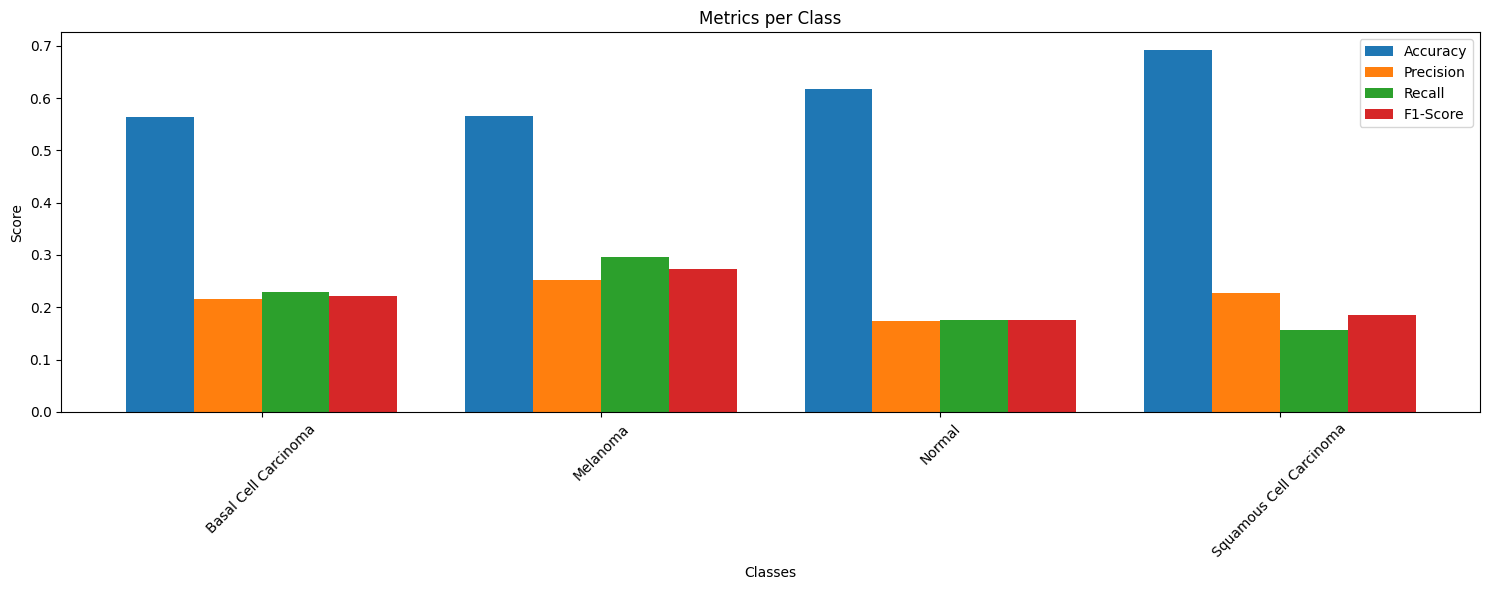

In [31]:
# Menampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Visualisasi metrik per kelas dalam bentuk bar chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
class_metrics = []

for idx in range(len(class_labels)):
    metrics = calculate_metrics_per_class(cm, idx)
    class_metrics.append([metrics[metric] for metric in metrics_names])

class_metrics = np.array(class_metrics)

# Plot bar chart untuk setiap metrik
plt.figure(figsize=(15, 6))
x = np.arange(len(class_labels))
width = 0.2

for i, metric in enumerate(metrics_names):
    plt.bar(x + i*width, class_metrics[:, i], width, label=metric)

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Metrics per Class')
plt.xticks(x + width*1.5, class_labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# optimizer_adam = Adam(learning_rate=1e-4)
# sgd_compiler = SGD(learning_rate=0.01, momentum=0.9)

# model.compile(
#     optimizer=optimizer_adam,
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# # callbacks
# eary_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=10,
#     restore_best_weights=True
# )

# reduce_lr = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     verbose=1
# )

In [ ]:
# history = model.fit(
#     train_gen,
#     steps_per_epoch=val_test_datagen.samples // val_test_datagen.batch_size,
#     epochs=40,
#     validation_data=val_test_datagen,
#     validation_steps=val_test_datagen.samples // val_test_datagen.batch_size,
#     verbose=2,
#     callbacks=[eary_stop, reduce_lr]
# )

In [9]:
# from tensorflow.keras.applications import EfficientNetB0
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
# from tensorflow.keras.optimizers import Adam

# # Load arsitektur EfficientNetB0
# base_model = EfficientNetB0(
#     weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# # Tambahkan layer custom
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# predictions = Dense(len(labels), activation='softmax')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

# # Freeze pretrained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Compile model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='categorical_crossentropy', metrics=['accuracy'])

# # Train model
# history = model.fit(train_gen, validation_data=val_gen, epochs=15)

In [10]:
# import cv2
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import classification_report

# # Ekstraksi fitur HOG
# def extract_hog_features(image_dir):
#     data, labels = [], []
#     for cls in labels:
#         cls_dir = os.path.join(image_dir, cls)
#         for file in os.listdir(cls_dir):
#             img = cv2.imread(os.path.join(cls_dir, file), cv2.IMREAD_GRAYSCALE)
#             img = cv2.resize(img, (128, 128))
#             hog = cv2.HOGDescriptor()
#             h = hog.compute(img).flatten()
#             data.append(h)
#             labels.append(cls)
#     return data, labels


# # Ekstraksi fitur
# train_data, train_labels = extract_hog_features('./dataset/split/train')
# test_data, test_labels = extract_hog_features('./dataset/split/test')

# # Train Random Forest
# rf = RandomForestClassifier()
# rf.fit(train_data, train_labels)

# # Evaluate
# preds = rf.predict(test_data)
# print(classification_report(test_labels, preds))

In [11]:
# # Plot evaluasi
# import matplotlib.pyplot as plt

# # Accuracy plot
# plt.plot(history.history['accuracy'], label='Train Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.legend()
# plt.title('Model Accuracy')
# plt.show()

# # Loss plot
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.legend()
# plt.title('Model Loss')
# plt.show()

In [12]:
# test_loss, test_acc = model.evaluate(test_gen)
# print(f"Test Accuracy: {test_acc:.2f}")